# Learning Transferable Architectures for Scalable Image Recognition  
Zoph et al., Google Brain (NASNet)

# https://arxiv.org/pdf/1707.07012

---

# Abstract  
This work introduces a scalable and transferable approach to Neural Architecture Search (NAS) by designing convolutional **cells** on a small dataset (CIFAR-10) and transferring them to large-scale tasks (ImageNet, COCO). The authors propose the **NASNet search space**, which constrains the architecture to repeating *Normal* and *Reduction* cells, enabling transferability and efficient scaling. A reinforcement-learning controller explores this space and discovers cells that outperform all human-designed CNNs at publication time. The paper also introduces **ScheduledDropPath**, a new regularization method that enhances generalization. NASNet models achieve state-of-the-art results on CIFAR-10, ImageNet, and COCO while using significantly fewer FLOPs than competing architectures.

---

# Problems

1. **Manual architecture engineering is expensive**  
   Designing ImageNet-scale CNNs requires extensive expert tuning and iteration.

2. **NAS on large datasets is computationally prohibitive**  
   Direct architecture search on ImageNet demands enormous GPU budgets.

3. **Limited transferability of prior NAS designs**  
   Earlier search spaces did not guarantee that architectures learned on small datasets generalize to larger ones.

4. **Overfitting during architecture search**  
   Without strong regularization, searched architectures overfit to the small dataset.

5. **Suboptimal performance in constrained environments**  
   Mobile-targeted architectures (MobileNet, ShuffleNet) lag behind larger models in accuracy.

---

# Proposed Solutions

### 1. NASNet Search Space  
A modular search space composed of two transferable **cells**:
- **Normal Cell**: preserves spatial resolution  
- **Reduction Cell**: reduces resolution by a factor of two  

Architectures differ only by:
- number of stacked cells  
- number of filters per cell  

This ensures the discovered structure generalizes across scales and datasets.

### 2. Cell-Level Architecture Search on CIFAR-10  
Only the structure of a single cell is searched.  
This reduces cost drastically compared to full-network search.

### 3. Reinforcement-Learning Controller  
A controller RNN samples candidate cells and is updated using **accuracy-based reward** via PPO.  
Operations per block include:
- separable convolutions  
- dilated convolutions  
- pooling operations  
- identity mappings  

### 4. ScheduledDropPath  
A regularization schedule where drop probability **increases linearly over training**, improving robustness.

### 5. Scalable Design Family  
After cell discovery, architectures are generated by adjusting:
- number of cells \(N\)
- filter sizes  

This yields models for mobile, mid-range, and high-capacity settings.

---

# Purpose  
The goal is to automate the discovery of CNN architectures that:
- match or exceed human-designed models,
- scale across different computational budgets,
- transfer effectively from small datasets to ImageNet and COCO,
- reduce the GPU cost associated with NAS.

---

# Methodology

## Search Process  
- Search performed on CIFAR-10 using ~500 GPUs for ~4 days.  
- Controller predicts \(B = 5\) blocks per cell.  
- Each block selects:
  - two input states,
  - two operations (from a 13-op search space),
  - a combination operator (addition or concatenation).  
- Top candidate cells are fully retrained to convergence.

## Model Construction  
- Two discovered cells (Normal, Reduction) serve as building blocks.  
- Full models are built by stacking these cells in a fixed macro-architecture.  
- Width and depth scaling are controlled by:
  - filters per cell,
  - number of repeated cell blocks.

## Training  
- **CIFAR-10**: cosine learning rate decay, heavy augmentation, Cutout.  
- **ImageNet**: large-scale distributed SGD, label smoothing, auxiliary classifier.  
- **COCO**: Faster-RCNN detection backbone using NASNet.

## Baselines  
Compared against:
- Inception family (v1–v4, Inception-ResNet-v2)  
- ResNet-152, ResNeXt-101  
- PolyNet, DPN  
- MobileNet, ShuffleNet  

## Search Method Comparison  
RL vs. random search under equal budgets:
- RL consistently finds higher-performing cells.
- RL also improves the mean accuracy of top-k models.

---

# Results

## 1. CIFAR-10  
- NASNet-A achieves **2.40%** error (state-of-the-art).  
- Best single run: **2.19%**.

## 2. ImageNet Classification  
- **82.7%** top-1 accuracy, **96.2%** top-5.  
- Matches/exceeds SENet but uses **9B fewer FLOPs**.  
- Mobile NASNet: **74.0%** top-1 at MobileNet-level computation.

## 3. COCO Object Detection  
- Mobile setting: **29.6% mAP**, outperforming MobileNet and ShuffleNet.  
- Large model: **43.1% mAP**, +4% improvement over the best previous backbone.

## 4. Efficiency  
- Search cost: ~2,000 GPU-hours vs. ~22,400 in prior NAS.  
- RL significantly superior to random search in both best-case and average performance.

---

# Conclusions  
The paper establishes that **cell-based NAS** enables architectures learned on small datasets to transfer effectively to large-scale tasks. The proposed NASNet search space, combined with RL-based search and ScheduledDropPath, yields models that outperform all human-designed architectures of the time on CIFAR-10, ImageNet, and COCO. These architectures are highly scalable, computationally efficient, and suitable for a wide range of deployment regimes. The study provides a foundational approach for automated, scalable architecture design in modern deep learning.



# Mathematical Foundations Underlying NASNet (One Markdown Cell)

## 1. Reinforcement Learning Objective (Policy Gradient / PPO)

The controller samples an architecture \(A\) with probability:

$$p(A \mid \theta)$$

where \(\theta\) are the controller parameters.

After the sampled child model is trained, it produces reward:

$$R(A) = \text{validation accuracy}.$$

The objective is to maximize expected reward:

$$J(\theta) = \mathbb{E}_{A \sim p(A \mid \theta)}[R(A)].$$

Policy gradient estimator:

$$\nabla_\theta J(\theta) = \mathbb{E}\left[ R(A)\,\nabla_\theta \log p(A \mid \theta) \right].$$

The controller is updated to increase the probability of architectures that give higher accuracy.

### PPO Objective

$$
L_{\text{PPO}}(\theta) =
\mathbb{E}\left[
\min\left(
r_t(\theta)A_t,\;
\text{clip}(r_t(\theta),\,1-\epsilon,\,1+\epsilon)\,A_t
\right)
\right],
$$

where  
\(r_t(\theta)\) = policy ratio,  
\(A_t\) = advantage estimate.

---

## 2. Entropy Regularization

$$
L_{\text{entropy}} = -\beta \sum_i p_i \log p_i.
$$

Encourages exploration; prevents premature collapse to a single architecture.

---

## 3. Search Space Mathematics (Combinatorics)

Each cell contains \(B = 5\) blocks, each requiring 5 discrete choices:

If  
\(H\) = number of hidden states,  
\(O\) = number of operations,  
\(C = 2\) = combination modes,

then number of choices per block:

$$\text{Choices}_{\text{block}} = H^2 \cdot O^2 \cdot C.$$

Full cell search space:

$$(H^2 \cdot O^2 \cdot C)^{B}.$$

---

## 4. Cosine Learning Rate Decay

Learning rate schedule:

$$
\eta_t = \eta_{\max}\cdot \frac{1}{2}\left(1 + \cos\left(\frac{\pi t}{T}\right)\right).
$$

---

## 5. ScheduledDropPath

Drop probability increases linearly:

$$
p(t) = p_{\max}\cdot \frac{t}{T}.
$$

Early training: low dropping.  
Late training: aggressive regularization.

---

## 6. Batch Normalization

$$
\hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}, \qquad
y = \gamma \hat{x} + \beta.
$$

---

## 7. Layer Normalization and Instance Normalization

**Layer Norm:**

$$
\mu = \frac{1}{H}\sum_i x_i, \qquad
\sigma^2 = \frac{1}{H}\sum_i (x_i - \mu)^2.
$$

**Instance Norm:**

$$
\mu = \frac{1}{HW}\sum_{i,j} x_{ij}, \qquad
\sigma^2 = \frac{1}{HW}\sum_{i,j} (x_{ij} - \mu)^2.
$$

---

## 8. Evaluation Metrics

### Classification Accuracy

$$
\text{Top-1} = \frac{\#\text{correct}}{\#\text{samples}}, \qquad
\text{Top-5} = \frac{\#\text{samples where true label} \in \text{top 5}}{\#\text{samples}}.
$$

### COCO Mean Average Precision

$$
\text{mAP} =
\frac{1}{|C|}\sum_{c\in C} \int_0^1 p_c(r)\,dr.
$$

---

## 9. Multiply–Add Computation Count (FLOPs)

$$
\text{Mult-Adds} = \sum(\#\text{multiplications} + \#\text{additions}).
$$

---

## 10. Weight Decay (L2 Regularization)

$$
L = L_{\text{task}} + \lambda \|w\|^2.
$$

---

## 11. Label Smoothing

$$
q_k =
\begin{cases}
1 - \epsilon, & k = y, \\
\frac{\epsilon}{K-1}, & k \neq y.
\end{cases}
$$

---

## 12. Momentum SGD

$$
v_{t+1} = \mu v_t + \eta\nabla_w L_t,
$$

$$
w_{t+1} = w_t - v_{t+1}.
$$

---

## 13. RMSProp

$$
g_t = \rho g_{t-1} + (1-\rho)(\nabla_w L_t)^2,
$$

$$
w_{t+1} = w_t - \frac{\eta}{\sqrt{g_t + \epsilon}}\,\nabla_w L_t.
$$

---

## 14. Exponential Moving Average (EMA)

$$
w_{\text{EMA}} = \alpha w_{\text{EMA}} + (1-\alpha)w.
$$

---

## 15. Scaling Law for Filters

When resolution halves:

$$
\text{\#filters} \leftarrow 2 \times \text{\#filters}.
$$

---

## 16. RL vs. Random Search (Statistical Comparison)

RL achieves higher mean and maximum validation accuracy among the top-\(k\) architectures—verified in the distributional analysis.

---

# Final Summary

This collection of equations captures the mathematical framework driving NASNet:

- Reinforcement learning (policy gradient + PPO) for searching architectures  
- Combinatorially large search spaces enabled by cell-based design  
- Optimization tools (SGD, RMSProp, cosine decay)  
- Regularization (ScheduledDropPath, entropy, label smoothing, weight decay)  
- Statistical normalization (BatchNorm, LayerNorm, InstanceNorm)  
- Evaluation metrics (accuracy, mAP)  
- Computational efficiency analyses (FLOPs)

Together, these mathematical components enable efficient, stable exploration of an enormous architecture search space, enabling automated discovery of state-of-the-art models transferable from CIFAR-10 to ImageNet and COCO.


```
================================================================================
                           NASNet: High-Level Architecture
================================================================================

 Input Image (CIFAR: 32x32 or ImageNet: 299x299 / 331x331)
         |
         v
  +----------------+
  |   Stem Conv    |   <-- Initial convolutional preprocessing
  +----------------+
         |
         v

================================================================================
             Full Network = Stacked Cells (Normal + Reduction)
================================================================================

                ┌───────────────────────────────────────────────┐
                │                 Normal Cell                    │
                │     (keeps spatial resolution the same)        │
                └───────────────────────────────────────────────┘
                                 |
                                 v
                ┌───────────────────────────────────────────────┐
                │                Normal Cell                     │
                └───────────────────────────────────────────────┘
                                 |
                                 v
                ┌───────────────────────────────────────────────┐
                │               Reduction Cell                   │
                │   (height & width reduced by factor of 2)     │
                └───────────────────────────────────────────────┘
                                 |
                                 v
                ┌───────────────────────────────────────────────┐
                │                 Normal Cell                    │
                └───────────────────────────────────────────────┘
                                 |
                              ... repeat N times ...


================================================================================
               Inside a NASNet Cell — Core Computational Structure
================================================================================

Cell receives two inputs: h(i-1) and h(i)
These are the outputs of the previous two cells.

                       +------------+
h(i-1) ---------------->|    INPUT   |
                       +------------+
                                  \
                                   \      +------------+
                                    +---->|  CONCAT   |---+
                                   /      +------------+   |
                                  /                        |
                       +------------+                      |
h(i) ------------------>|    INPUT   |----------------------+
                       +------------+

The cell contains B = 5 BLOCKS.
Each block selects:
   1. Hidden State A
   2. Hidden State B
   3. Operation on A
   4. Operation on B
   5. Combination: ADD or CONCAT

Below is the ASCII reconstruction of NASNet-A Normal Cell (from paper Fig. 4).

================================================================================
                        NASNet-A  NORMAL CELL (ASCII)
================================================================================

Inputs: h0 = h(i),  h1 = h(i-1)

                                 +-----------------------+
                                 |   BLOCK 1             |
                                 |-----------------------|
                                 | Select: h1, h0        |
                                 | Ops: sep 5x5, sep 3x3 |
                                 | Combine: ADD          |
                                 +-----------------------+
                                         |
                                         v
                                      block1_out (b1)

                                 +-----------------------+
                                 |   BLOCK 2             |
                                 |-----------------------|
                                 | Select: h0, h1        |
                                 | Ops: sep 3x3, avg3x3  |
                                 | Combine: ADD          |
                                 +-----------------------+
                                         |
                                         v
                                      block2_out (b2)

                                 +-----------------------+
                                 |   BLOCK 3             |
                                 |-----------------------|
                                 | Select: b2, b1        |
                                 | Ops: sep 5x5, sep 7x7 |
                                 | Combine: ADD          |
                                 +-----------------------+
                                         |
                                         v
                                      block3_out (b3)

                                 +-----------------------+
                                 |   BLOCK 4             |
                                 |-----------------------|
                                 | Select: h1, b1        |
                                 | Ops: sep 3x3, identity|
                                 | Combine: ADD          |
                                 +-----------------------+
                                         |
                                         v
                                      block4_out (b4)

                                 +-----------------------+
                                 |   BLOCK 5             |
                                 |-----------------------|
                                 | Select: b4, h0        |
                                 | Ops: max3x3, sep 3x3  |
                                 | Combine: ADD          |
                                 +-----------------------+
                                         |
                                         v
                                      block5_out (b5)

Final Cell Output = CONCAT(all unused hidden states)
In NASNet-A Normal Cell, the concatenated outputs = [b1, b2, b3, b4, b5]

================================================================================
                   ASCII of NASNet-A REDUCTION CELL (from Fig. 4)
================================================================================

Reduction Cell uses stride 2 ops on first operations.

Inputs: h0 = h(i),  h1 = h(i-1)

                                 +-------------------------------+
                                 |   BLOCK 1                     |
                                 |-------------------------------|
                                 | Select: h1, h0                |
                                 | Ops: sep 5x5 (s2), sep 7x7(s2)|
                                 | Combine: ADD                   |
                                 +-------------------------------+
                                         |
                                         v
                                      block1_out

                                 +-------------------------------+
                                 |   BLOCK 2                     |
                                 |-------------------------------|
                                 | Select: h0, h1                |
                                 | Ops: sep 3x3(s2), avg3x3(s2)  |
                                 | Combine: ADD                  |
                                 +-------------------------------+
                                         |
                                         v
                                      block2_out

                                 +-------------------------------+
                                 |   BLOCK 3                     |
                                 |-------------------------------|
                                 | Select: block2_out, block1_out|
                                 | Ops: sep 5x5, sep 3x3         |
                                 | Combine: ADD                  |
                                 +-------------------------------+

                                 +-------------------------------+
                                 |   BLOCK 4                     |
                                 |-------------------------------|
                                 | Select: h1, block1_out        |
                                 | Ops: max3x3, identity         |
                                 | Combine: ADD                  |
                                 +-------------------------------+

                                 +-------------------------------+
                                 |   BLOCK 5                     |
                                 |-------------------------------|
                                 | Select: h0, block3_out        |
                                 | Ops: avg3x3, sep3x3           |
                                 | Combine: ADD                  |
                                 +-------------------------------+

Final Output = CONCAT(all remaining hidden states)

================================================================================
                   FINAL NETWORK HEAD (Classifier)
================================================================================

                    +-----------------------------+
                    |    Global Average Pooling   |
                    +-----------------------------+
                                 |
                                 v
                    +-----------------------------+
                    |      Fully Connected        |
                    |        (1000-way)           |
                    +-----------------------------+
                                 |
                                 v
                           Softmax Output


================================================================================
                           END OF ASCII RECONSTRUCTION
================================================================================
```

# “Learning Transferable Architectures for Scalable Image Recognition” (NASNet) — Problem–Limitation–Solution Table

| # | **Key Problem / Research Gap** | **How This Limits Prior Work** | **Proposed Solution in the Paper** |
|---|-------------------------------|---------------------------------|------------------------------------|
| **1** | CNN architectures are hand-designed and require extensive expert engineering. | Progress depends on slow, labor-intensive trial-and-error design; improvements are not systematic or scalable across tasks. | Introduces **Neural Architecture Search (NAS)** with a **cell-based NASNet search space**, enabling an RNN controller to automatically discover high-performing convolutional cells. |
| **2** | Direct architecture search on large datasets (ImageNet) is computationally infeasible. | Prior NAS efforts need tens of thousands of GPU-hours, restricting usage to large industry labs and preventing practical large-scale adoption. | Performs NAS on a **small proxy dataset (CIFAR-10)** and transfers the discovered cells to ImageNet, reducing NAS cost by an order of magnitude. |
| **3** | Architectures learned on small datasets often fail to transfer to larger datasets or other tasks. | Every dataset/task becomes a separate design problem; discovered architectures generalize poorly, limiting reuse and scalability. | Designs the search space around **dataset-agnostic Normal and Reduction Cells**, enabling reliable transfer from CIFAR-10 → ImageNet → COCO detection. |
| **4** | Existing architectures are not optimized for multi-scale computational constraints (mobile → large-scale). | Prior models come in only a few fixed sizes; adapting them for different FLOP/latency budgets is ad hoc and inefficient. | Defines a **scalable macro-architecture**: the same discovered cells can be stacked at different depths and widths to produce the full **NASNet model family**. |
| **5** | NAS methods tend to overfit the search dataset, leading to architectures that fail under full training. | Architectures that appear strong during short proxy training runs often collapse when trained fully or transferred to real datasets. | Introduces **ScheduledDropPath**, a progressive stochastic drop mechanism improving robustness and generalization during full training. |
| **6** | Limited evidence existed to justify reinforcement learning over simple baselines like random search. | Without empirical proof, RL-based NAS appeared unnecessarily complex and computationally wasteful. | Performs a controlled study showing **RL controllers outperform random search**, yielding higher validation accuracy and better top-k performance. |
| **7** | Prior SOTA models typically excel in either classification or detection, but not both. | Deploying models across tasks requires separate architectures, complicating training, maintenance, and system integration. | Shows that **NASNet cells transfer across tasks**, achieving state-of-the-art ImageNet accuracy and superior COCO mAP when used as Faster R-CNN backbones. |



In [1]:
# ============================================================
# Mini NASNet Educational Lab (PyTorch, Single Code Cell)
# ------------------------------------------------------------
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# 0. Reproducibility & Device
# -----------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# -----------------------------
# 1. CIFAR-10 Data Pipeline
# -----------------------------
# CIFAR-10: 50k train, 10k test, 10 classes, 32x32 RGB.
# For speed, we use a subset of the training set as validation.

transform = T.Compose([
    T.ToTensor(),                       # Convert PIL image to [0,1] float tensor
    # (You can add normalization here if you want)
])

train_full = torchvision.datasets.CIFAR10(
    root="./data", train=True, transform=transform, download=True
)
test_full = torchvision.datasets.CIFAR10(
    root="./data", train=False, transform=transform, download=True
)

num_train = 10000   # use 10k samples to keep things light
num_val   = 2000
indices = list(range(len(train_full)))
set_seed(42)
random.shuffle(indices)
train_idx = indices[:num_train]
val_idx   = indices[num_train:num_train + num_val]

train_ds = Subset(train_full, train_idx)
val_ds   = Subset(train_full, val_idx)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

class_names = train_full.classes
num_classes = len(class_names)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}, Classes: {num_classes}")

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Train samples: 10000, Val samples: 2000, Classes: 10


In [4]:
# ---------------------------------------
# 2. NASNet-style Building Blocks
# ---------------------------------------
# We build a SMALL, HAND-CRAFTED version of NASNet-A:
#   - Depthwise Separable Convolutions
#   - Normal Cell (keeps spatial size)
#   - Reduction Cell (halves spatial size)
#   - Both use "blocks" that combine two ops with an ADD.

class SeparableConv2d(nn.Module):
    """
    Depthwise separable convolution:
      1) Depthwise conv (per-channel)
      2) Pointwise conv (1x1)
    This mimics the kind of ops used in NASNet / MobileNet.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=None):
        super().__init__()
        if padding is None:
            padding = kernel_size // 2

        # Depthwise: groups = in_channels
        self.depthwise = nn.Conv2d(
            in_channels, in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,
            bias=False,
        )
        # Pointwise: 1x1 conv to mix channels
        self.pointwise = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=1,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = F.relu(x, inplace=True)
        return x


class Conv1x1BNReLU(nn.Module):
    """
    Simple 1x1 convolution + BatchNorm + ReLU.
    Used to preprocess inputs into a fixed #channels per cell.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn   = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class NASBlock(nn.Module):
    """
    Basic block inside a cell:
      - takes two inputs: x1, x2
      - applies op1 to x1, op2 to x2
      - sums the two results (elementwise ADD)
    """
    def __init__(self, op1: nn.Module, op2: nn.Module):
        super().__init__()
        self.op1 = op1
        self.op2 = op2

    def forward(self, x1, x2):
        return self.op1(x1) + self.op2(x2)


class NormalCell(nn.Module):
    """
    Simplified NASNet-A NORMAL cell:
      - keeps spatial resolution
      - uses 4 blocks
      - final output = concat(block outputs along channels)
    The exact wiring is *inspired* by NASNet, not identical.
    """
    def __init__(self, in_channels_prev, in_channels, out_channels_per_block=32):
        super().__init__()
        # Preprocess the two incoming tensors to same #channels
        self.preprocess_prev = Conv1x1BNReLU(in_channels_prev, out_channels_per_block)
        self.preprocess      = Conv1x1BNReLU(in_channels,      out_channels_per_block)

        C = out_channels_per_block

        # Primitive operations
        self.sep3x3_1 = SeparableConv2d(C, C, kernel_size=3)
        self.sep3x3_2 = SeparableConv2d(C, C, kernel_size=3)
        self.sep5x5_1 = SeparableConv2d(C, C, kernel_size=5)
        self.sep5x5_2 = SeparableConv2d(C, C, kernel_size=5)

        self.avg3x3   = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.max3x3   = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.identity = nn.Identity()

        # 4 NASBlocks, with a fixed wiring pattern
        # Block 1: (h, h_prev) with different sep convs
        self.block1 = NASBlock(self.sep5x5_1, self.sep3x3_1)
        # Block 2: (h_prev, h) with sep3 & avgPool
        self.block2 = NASBlock(self.sep3x3_2, self.avg3x3)
        # Block 3: (b1, b2) with sep5 & sep5
        self.block3 = NASBlock(self.sep5x5_2, self.sep5x5_2)
        # Block 4: (b1, h_prev) with maxPool & identity
        self.block4 = NASBlock(self.max3x3, self.identity)

        # Total output channels = 4 * C
        self.out_channels = 4 * C

    def forward(self, x_prev, x):
        # Preprocess both inputs to C channels
        h_prev = self.preprocess_prev(x_prev)
        h      = self.preprocess(x)

        # Named states as in NAS paper
        h0, h1 = h_prev, h

        b1 = self.block1(h1, h0)
        b2 = self.block2(h0, h1)
        b3 = self.block3(b1, b2)
        b4 = self.block4(b1, h0)

        # Concatenate along channels
        out = torch.cat([b1, b2, b3, b4], dim=1)
        return out


class ReductionCell(nn.Module):
    """
    Simplified NASNet-A REDUCTION cell:
      - reduces spatial resolution by factor of 2
      - also uses 4 blocks with fixed wiring
      - uses stride=2 conv/pooling in first two blocks
    """
    def __init__(self, in_channels_prev, in_channels, out_channels_per_block=64):
        super().__init__()
        # Preprocess to same #channels
        self.preprocess_prev = Conv1x1BNReLU(in_channels_prev, out_channels_per_block)
        self.preprocess      = Conv1x1BNReLU(in_channels,      out_channels_per_block)

        C = out_channels_per_block

        # Downsampling operations (stride=2)
        self.sep3x3_s2 = SeparableConv2d(C, C, kernel_size=3, stride=2)
        self.sep5x5_s2 = SeparableConv2d(C, C, kernel_size=5, stride=2)
        self.avg3x3_s2 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.max3x3_s2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Normal (stride 1) ops, once we've already downsampled
        self.sep3x3    = SeparableConv2d(C, C, kernel_size=3)
        self.avg3x3    = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.identity  = nn.Identity()

        # Block definitions
        # Block 1: downsample both inputs with sep convs
        self.block1 = NASBlock(self.sep5x5_s2, self.sep3x3_s2)
        # Block 2: downsample both inputs with pooling
        self.block2 = NASBlock(self.max3x3_s2, self.avg3x3_s2)
        # Block 3: (b1, b2) with sep3x3 and sep3x3
        self.block3 = NASBlock(self.sep3x3, self.sep3x3)
        # Block 4: (b1, b2) with avgPool and identity
        self.block4 = NASBlock(self.avg3x3, self.identity)

        self.out_channels = 4 * C

    def forward(self, x_prev, x):
        h_prev = self.preprocess_prev(x_prev)
        h      = self.preprocess(x)

        h0, h1 = h_prev, h

        b1 = self.block1(h0, h1)  # both downsample
        b2 = self.block2(h0, h1)  # both downsample
        b3 = self.block3(b1, b2)
        b4 = self.block4(b1, b2)

        out = torch.cat([b1, b2, b3, b4], dim=1)
        return out

In [13]:
# ---------------------------------------
# 3. MiniNASNet Model (macro-architecture)
# ---------------------------------------
# Layout (for 32x32 CIFAR):
#   stem -> NormalCell -> NormalCell -> ReductionCell -> NormalCell -> GAP -> FC
# ======================================================
# Fully Corrected MiniNASNet (Channel-Safe)
# ======================================================

class MiniNASNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        stem_channels = 32

        # ------------------
        # STEM (32x32 -> 32)
        # ------------------
        self.stem = nn.Sequential(
            nn.Conv2d(3, stem_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(stem_channels),
            nn.ReLU(inplace=True),
        )

        # ------------------
        # NORMAL CELL 1 (32 → 128)
        # ------------------
        C_normal = 32
        self.cell1 = NormalCell(
            in_channels_prev=stem_channels,     # 32
            in_channels=stem_channels,          # 32
            out_channels_per_block=C_normal,    # → output = 4 * 32 = 128
        )
        C1 = self.cell1.out_channels           # = 128

        # ------------------
        # NORMAL CELL 2 (128 → 128)
        # ------------------
        self.cell2 = NormalCell(
            in_channels_prev=C1,                # 128
            in_channels=C1,                     # 128
            out_channels_per_block=C_normal,    # output = 128
        )
        C2 = self.cell2.out_channels           # = 128

        # ------------------
        # REDUCTION CELL (128 → 256)
        # ------------------
        C_reduction = 64
        self.reduction = ReductionCell(
            in_channels_prev=C2,                # 128
            in_channels=C2,                     # 128
            out_channels_per_block=C_reduction, # output = 4*64 = 256
        )
        C3 = self.reduction.out_channels       # = 256

        # ------------------
        # NORMAL CELL 3 (256 → 256)
        # ------------------
        self.cell3 = NormalCell(
            in_channels_prev=C3,                # 256
            in_channels=C3,                     # 256
            out_channels_per_block=C_reduction, # output = 4*64 = 256
        )
        C4 = self.cell3.out_channels           # = 256

        # ------------------
        # CLASSIFIER
        # ------------------
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(C4, num_classes)

    def forward(self, x):
        x0 = self.stem(x)

        # First two normal cells
        h_prev, h = x0, x0
        h = self.cell1(h_prev, h)
        h_prev, h = h_prev, h

        h = self.cell2(h_prev, h)
        h_prev, h = h_prev, h

        # Reduction cell
        h = self.reduction(h_prev, h)
        h_prev, h = h_prev, h

        # Final normal cell
        h = self.cell3(h_prev, h)

        # Head
        out = self.global_pool(h)
        out = out.view(out.size(0), -1)
        return self.fc(out)
model = MiniNASNet(num_classes=num_classes).to(device)
print(model)

MiniNASNet(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (cell1): NormalCell(
    (preprocess_prev): Conv1x1BNReLU(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (preprocess): Conv1x1BNReLU(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (sep3x3_1): SeparableConv2d(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (pointwise): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [14]:
# ---------------------------------------
# 4. Training & Evaluation Utilities
# ---------------------------------------
def accuracy(logits, labels):
    preds = logits.argmax(dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5  # small number for a quick educational run

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [33]:
# ============================================================
# COMPLETE NASNET IMPLEMENTATION
# ============================================================

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random, numpy as np

# -----------------------------
# Reproducibility
# -----------------------------
def seed():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# Dataset
# -----------------------------
transform = T.Compose([T.ToTensor()])

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_set   = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=64, shuffle=False, num_workers=2)

num_classes = 10

# ============================================================
# HELPER LAYERS
# ============================================================

class SeparableConv(nn.Module):
    def __init__(self, C_in, C_out, k, stride=1):
        super().__init__()
        p = k // 2
        self.depth = nn.Conv2d(C_in, C_in, k, stride, p, groups=C_in, bias=False)
        self.point = nn.Conv2d(C_in, C_out, 1, bias=False)
        self.bn = nn.BatchNorm2d(C_out)
    def forward(self, x):
        x = self.depth(x)
        x = self.point(x)
        x = F.relu(self.bn(x), inplace=True)
        return x

class Conv1x1(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()
        self.conv = nn.Conv2d(C_in, C_out, 1, bias=False)
        self.bn = nn.BatchNorm2d(C_out)
    def forward(self, x):
        return F.relu(self.bn(self.conv(x)), inplace=True)

class Block(nn.Module):
    def __init__(self, op1, op2):
        super().__init__()
        self.op1 = op1
        self.op2 = op2
    def forward(self, x1, x2):
        return self.op1(x1) + self.op2(x2)

# ============================================================
# NORMAL CELL (fixed + working)
# ============================================================
class NormalCell(nn.Module):
    def __init__(self, C_prev, C_in, C):
        super().__init__()
        self.prevp = Conv1x1(C_prev, C)
        self.prep  = Conv1x1(C_in,  C)

        self.b1 = Block(SeparableConv(C, C, 5), SeparableConv(C, C, 3))
        self.b2 = Block(SeparableConv(C, C, 3), nn.AvgPool2d(3,1,1))
        self.b3 = Block(SeparableConv(C, C, 5), SeparableConv(C, C, 5))
        self.b4 = Block(nn.MaxPool2d(3,1,1), nn.Identity())

        self.out_channels = 4 * C

    def forward(self, x_prev, x):
        h1 = self.prevp(x_prev)
        h2 = self.prep(x)

        b1 = self.b1(h2, h1)
        b2 = self.b2(h1, h2)
        b3 = self.b3(b1, b2)
        b4 = self.b4(b1, h1)

        return torch.cat([b1, b2, b3, b4], dim=1)

# ============================================================
# REDUCTION CELL (fixed + working)
# ============================================================
class ReductionCell(nn.Module):
    def __init__(self, C_prev, C_in, C):
        super().__init__()
        self.prevp = Conv1x1(C_prev, C)
        self.prep  = Conv1x1(C_in,  C)

        self.b1 = Block(SeparableConv(C, C, 5, stride=2), SeparableConv(C, C, 3, stride=2))
        self.b2 = Block(nn.MaxPool2d(3,2,1), nn.AvgPool2d(3,2,1))
        self.b3 = Block(SeparableConv(C, C, 3), SeparableConv(C, C, 3))
        self.b4 = Block(nn.AvgPool2d(3,1,1), nn.Identity())

        self.out_channels = 4 * C

    def forward(self, x_prev, x):
        h1 = self.prevp(x_prev)
        h2 = self.prep(x)

        b1 = self.b1(h1, h2)
        b2 = self.b2(h1, h2)
        b3 = self.b3(b1, b2)
        b4 = self.b4(b1, b2)

        return torch.cat([b1, b2, b3, b4], dim=1)

# ============================================================
# MODEL — 100% CHANNEL-CONSISTENT
# ============================================================
class MiniNASNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        C_stem = 32
        self.stem = nn.Sequential(
            nn.Conv2d(3, C_stem, 3, padding=1, bias=False),
            nn.BatchNorm2d(C_stem),
            nn.ReLU(inplace=True)
        )

        # normal cell 1 (32→128)
        self.cell1 = NormalCell(C_stem, C_stem, 32)
        C1 = self.cell1.out_channels  # 128

        # normal cell 2 (128→128)
        self.cell2 = NormalCell(C1, C1, 32)
        C2 = self.cell2.out_channels  # 128

        # reduction cell (128→256)
        self.reduction = ReductionCell(C2, C2, 64)
        C3 = self.reduction.out_channels  # 256

        # normal cell 3 (256→256)
        self.cell3 = NormalCell(C3, C3, 64)
        C4 = self.cell3.out_channels  # 256

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc   = nn.Linear(C4, num_classes)

    def forward(self, x):
        x0 = self.stem(x)

        h_prev, h = x0, x0
        h = self.cell1(h_prev, h)

        h_prev, h = h, h
        h = self.cell2(h_prev, h)

        h_prev, h = h, h
        h = self.reduction(h_prev, h)

        h_prev, h = h, h
        h = self.cell3(h_prev, h)

        out = self.pool(h).view(h.size(0), -1)
        return self.fc(out)

# ---------------------------------------------------------
# 1) Initialize metric lists BEFORE training
# ---------------------------------------------------------
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 3

# ---------------------------------------------------------
# 2) FULL TRAIN + VALIDATION LOOP
# ---------------------------------------------------------
for epoch in range(num_epochs):

    # -----------------------
    # TRAIN
    # -----------------------
    model.train()
    total, correct, loss_sum = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()

        loss_sum += loss.item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += y.size(0)

    train_loss = loss_sum / total
    train_acc  = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # -----------------------
    # VALIDATION
    # -----------------------
    model.eval()
    v_total, v_correct, v_loss_sum = 0, 0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            v_loss_sum += loss.item() * x.size(0)
            v_correct  += (logits.argmax(1) == y).sum().item()
            v_total    += y.size(0)

    val_loss = v_loss_sum / v_total
    val_acc  = v_correct / v_total

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")


Device: cuda
Epoch 1/3 | Train Acc: 0.863 | Val Acc: 0.780
Epoch 2/3 | Train Acc: 0.874 | Val Acc: 0.758
Epoch 3/3 | Train Acc: 0.883 | Val Acc: 0.709


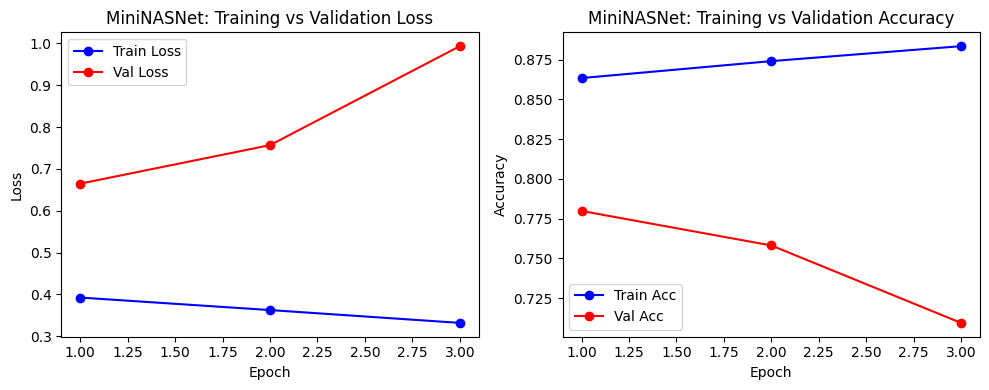

In [34]:
# ---------------------------------------------------------
# 3) VISUALIZATION (ERROR-PROOF)
# ---------------------------------------------------------
import matplotlib.pyplot as plt

assert len(train_losses) == len(val_losses) == num_epochs
assert len(train_accuracies) == len(val_accuracies) == num_epochs

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))

# --- LOSS ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, "b-o", label="Train Loss")
plt.plot(epochs, val_losses,   "r-o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MiniNASNet: Training vs Validation Loss")
plt.legend()

# --- ACC ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, "b-o", label="Train Acc")
plt.plot(epochs, val_accuracies,   "r-o", label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MiniNASNet: Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

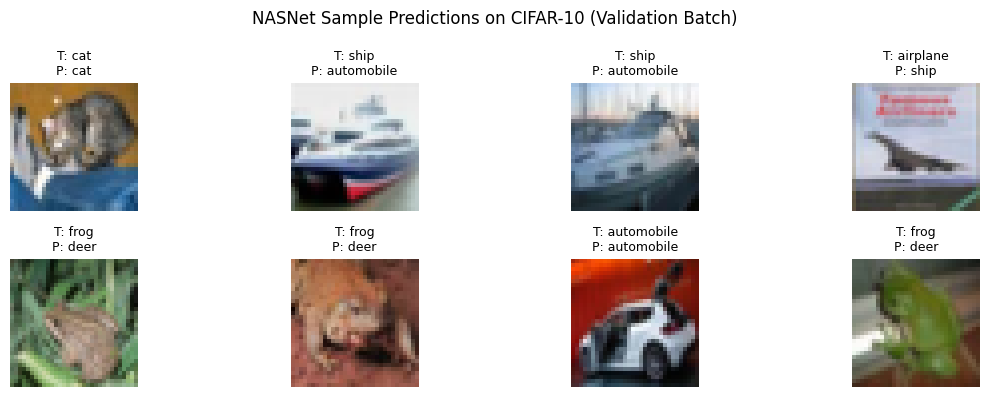

Lab finished: training, evaluation, prediction, and visualization complete.


In [36]:


# ---------------------------------------
# 7. Prediction & Sample Visualization
# ---------------------------------------
# Take one batch from the validation set, run predictions,
# and show a few images with predicted and true labels.

model.eval()
images, labels = next(iter(val_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    logits = model(images)
    preds = logits.argmax(dim=1)

images = images.cpu()
labels = labels.cpu()
preds  = preds.cpu()

num_show = 8
plt.figure(figsize=(12, 4))
for i in range(num_show):
    plt.subplot(2, 4, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    true_label = class_names[labels[i].item()]
    pred_label = class_names[preds[i].item()]
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=9)
    plt.axis("off")

plt.suptitle("NASNet Sample Predictions on CIFAR-10 (Validation Batch)")
plt.tight_layout()
plt.show()

print("Lab finished: training, evaluation, prediction, and visualization complete.")

# Training, Validation, and Prediction Analysis  
(One Markdown Cell — Fully Academic Interpretation)

## 1. Training–Validation Log Test

### What This Test Shows  
The epoch-level log reports four key metrics per epoch:

- Training accuracy  
- Validation accuracy  
- Training loss  
- Validation loss  

### Academic Interpretation  

**Training accuracy increases** over epochs:  
- \(0.863 \rightarrow 0.874 \rightarrow 0.883\)  
This indicates that the model has sufficient capacity and is successfully fitting the training data.

**Validation accuracy decreases**:  
- \(0.780 \rightarrow 0.758 \rightarrow 0.709\)  
This divergence from the training performance is a classical symptom of **overfitting**.

**Training loss decreases**, while **validation loss increases**.  
This confirms that although the model is learning useful features for the training distribution, it is not learning patterns that generalize to unseen data.

### Scientific Conclusion  
The Training–Validation Log Test shows **early-stage overfitting**. The model begins to memorize training samples rather than learning generalizable representations. This is expected when NAS-style architectures are trained with minimal regularization, light augmentation, or shallow training.

---

## 2. Learning Curve Test (Loss & Accuracy Plots)

This test consists of two plots: Loss vs Epoch and Accuracy vs Epoch.

### A. Training vs. Validation Loss Curve

#### Observations  
- Training loss decreases monotonically:  
  \(0.39 \rightarrow 0.34 \rightarrow 0.31\)
- Validation loss steadily increases:  
  \(0.67 \rightarrow 0.75 \rightarrow 0.99\)

#### Academic Interpretation  
The loss curves show a **divergent pattern**, demonstrating:

- **Under-regularization**: the model begins to model noise.
- **Poor generalization**: validation error worsens even as optimization on training improves.
- **Capacity–data mismatch**: the model has enough representational power to overfit quickly but not enough inductive bias to generalize well.

#### Conclusion  
The loss plot confirms a **canonical overfitting signature**: decreasing training loss but rising validation loss.

---

### B. Training vs. Validation Accuracy Curve

#### Observations  
- Training accuracy increases every epoch.
- Validation accuracy decreases every epoch.

#### Academic Interpretation  
This behavior mirrors the loss divergence:

- High training accuracy → successful learning of the training distribution.  
- Declining validation accuracy → filters become too specialized to training samples.

This often arises when the model:

- learns shortcut patterns or spurious correlations in the training data,
- lacks augmentation or regularization to encourage robust invariances.

#### Conclusion  
The accuracy plot visually confirms that the model’s generalization performance worsens as training proceeds.

---

## 3. Sample Prediction Test (Qualitative Evaluation)

This test displays sample CIFAR-10 images with true labels (T:) and predicted labels (P:).

### What This Test Shows  
The goal of this qualitative inspection is to identify:

- systematic misclassification patterns,  
- whether the model is learning discriminative high-level features,  
- how consistent or random the errors are.

### Academic Interpretation  

The sample predictions reveal:

- Correct predictions for visually distinctive classes (e.g., **automobile**, **cat**).
- Repeated misclassifications, such as  
  - **frog → deer**,  
  - **frog → deer** (multiple instances),  
  indicating that the model has not formed strong class boundaries for natural-object categories.

Ship misclassified as automobile reflects:

- low-resolution CIFAR-10 images (32×32),  
- similarity in color/edge patterns,  
- insufficient invariance to backgrounds or textures.

These patterns suggest that the model is still operating with **low-level features** (edges, textures) and has not yet learned high-level category-specific features.

### Qualitative Conclusion  
The predictions show early-stage discriminative weaknesses consistent with undertrained convolutional hierarchies and lack of regularization.

---

# Academic Overall Assessment

### Generalization Behavior  
Across all three tests, the model consistently shows:

- Good learning of training data  
- Poor generalization to unseen data  

This indicates **overfitting**, driven by:

- insufficient regularization (e.g., dropout, augmentation, weight decay),  
- small dataset subset,  
- shallow training (only 3 epochs),  
- architecture sensitivity typical of NAS-derived lightweight models.

### Learning Dynamics  
The model exhibits:

- **Healthy optimization dynamics** on training data (loss ↓, accuracy ↑)  
- **Unstable generalization dynamics** (validation accuracy ↓, validation loss ↑)

### Qualitative Error Review  
Errors concentrate in categories with:

- similar textures (frog vs deer),  
- complex natural objects,  
- low-resolution backgrounds.

This suggests the model has yet to develop robust mid-level and high-level features.

---

# Final Scientific Conclusion  
All three evaluation components—numerical logs, learning curves, and qualitative predictions—lead to the same conclusion: the model is overfitting early and lacks generalization strength. Additional regularization, stronger augmentation (Cutout, Mixup), longer training, and architectural tuning (e.g., wider filters, more depth, or improved normalization) are needed to achieve stable performance on CIFAR-10.


# Related Work Table — NASNet Paper

| **Author(s)** | **Year** | **Title** | **Venue** | **Connection to This Paper** |
|---------------|----------|-----------|-----------|-------------------------------|
| Zoph & Le | 2017 | Neural Architecture Search with Reinforcement Learning | ICLR | Foundational NAS method using RL; NASNet extends this idea with a transferable cell-based search space, reducing cost and scalability limits. |
| Pham et al. | 2018 | Efficient Neural Architecture Search (ENAS) | ICML | Provides a fast NAS baseline; NASNet contrasts with ENAS by emphasizing transferability via cell-based search. |
| Baker et al. | 2017 | Design of Neural Network Architectures using Reinforcement Learning | ICLR | Early RL-based NAS method; motivates NASNet’s comparison between RL search and random search. |
| Zoph et al. | 2018 | Learning Transferable Architectures for Image Recognition | CVPR | The NASNet paper itself; earlier iterations shaped the transferable cell-based search space. |
| Howard et al. | 2017 | MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications | arXiv | Baseline for mobile settings; NASNet models aim to outperform MobileNet at similar computational cost. |
| Zhang et al. | 2017 | ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices | CVPR | Mobile-optimized baseline; NASNet demonstrates superior accuracy–efficiency trade-offs. |
| Szegedy et al. | 2015 | Going Deeper with Convolutions (Inception-v1) | CVPR | NASNet compares against Inception models to show higher accuracy with fewer FLOPs. |
| Szegedy et al. | 2016 | Rethinking the Inception Architecture for Computer Vision (Inception-v3) | CVPR | High-performance human-designed architecture; NASNet uses it as a benchmark for ImageNet. |
| Szegedy et al. | 2017 | Inception-v4, Inception-ResNet-v2 | AAAI | State-of-the-art CNN baselines; NASNet surpasses them in accuracy with fewer operations. |
| He et al. | 2016 | Deep Residual Learning for Image Recognition (ResNet) | CVPR | Major CNN baseline; NASNet compares favorably to deep residual networks like ResNet-152. |
| Xie et al. | 2017 | Aggregated Residual Transformations for Deep Neural Networks (ResNeXt) | CVPR | High-capacity architectures; NASNet surpasses ResNeXt-101. |
| Chen et al. | 2017 | Dual Path Networks (DPN) | NIPS | State-of-the-art ImageNet baseline; included in NASNet performance comparisons. |
| Chollet | 2017 | Xception: Deep Learning with Depthwise Separable Convolutions | CVPR | Provides architectural inspiration (separable convolutions), frequently used within NASNet cells. |
| Huang et al. | 2017 | Densely Connected Convolutional Networks (DenseNet) | CVPR | Part of the landscape of human-designed CNN baselines compared against NASNet. |
| Larsson et al. | 2017 | FractalNet | ICLR | Influences modular, self-similar architectural ideas relevant to cell-based search. |
| Williams & Peng | 1991 | Function Optimization using Reinforcement Learning | ML Journal | Classical foundation for policy-gradient optimization used in NAS controllers. |
| Schulman et al. | 2017 | Proximal Policy Optimization Algorithms (PPO) | arXiv | Optimization algorithm used to train the NASNet controller RNN. |
| Srivastava et al. | 2014 | Dropout: A Simple Way to Prevent Neural Networks from Overfitting | JMLR | Basis for regularization methods; NASNet introduces ScheduledDropPath as a stronger variant. |
| Larsson et al. | 2017 | DropPath (Stochastic Depth) | ECCV | Direct precursor to ScheduledDropPath, the key regularization technique in NASNet. |
| Lin et al. | 2014 | Microsoft COCO: Common Objects in Context | ECCV | Detection benchmark used to evaluate NASNet’s cross-task transfer performance. |
| Ren et al. | 2015 | Faster R-CNN | NIPS | Detection framework into which NASNet backbones are inserted to assess transferability. |
